In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
import cvxpy as cp
from algorithms import policy_fitting, policy_fitting_with_a_kalman_constraint
import warnings
# warnings.filterwarnings('ignore')

In [2]:
n, m = 4, 2
A = np.array([
    [.99997, .039, 0, -.322],
    [-.065, .99681, 7.74, 0],
    [.02, -.101, .99571, 0],
    [0, 0, 1, 1]
])
B = np.array([
    [.0001, 0 ],
    [-.0018, -.0004 ],
    [-.0116, .00598 ],
    [0, 0]
])
W = .1*np.array([
    [ 1.00092109, -0.02610491,  0.016055  ,  0.        ],
    [-0.02610491,  0.99785518, -0.10197781,  0.        ],
    [ 0.016055  , -0.10197781,  0.010601  ,  0.        ],
    [ 0.        ,  0.        ,  0.        ,  0.        ]
])
Q_true = np.diag([1, 1, 1, 1])
R_true = np.diag([1, 1])
P_true = solve_discrete_are(A, B, Q_true, R_true)
K_true = -np.linalg.solve(R_true + B.T @ P_true @ B, B.T @ P_true @ A)
K_true

array([[ -0.79568859,  -1.13589763,  60.66228741, -13.17357764],
       [  0.07931146,   3.18269798, -29.89812673, -12.02371001]])

In [3]:
def simulate(K, N=10, seed=None, add_noise=False):
    if seed is not None:
        np.random.seed(seed)
    x = np.random.multivariate_normal(np.zeros(n), W)
    xs = []
    us = []
    cost = 0.0
    for _ in range(N):
        u = K @ x
        if add_noise:
            u += 5*np.random.randn(m)
        xs.append(x)
        us.append(u)
        cost += (x @ Q_true @ x + u @ R_true @ u) / N
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(n), W)
    xs = np.array(xs)
    us = np.array(us)
    
    return cost, xs, us

In [28]:
N_test = 100000
# cost_true = simulate(K_true, N=N_test, seed=0)[0]
# cost_noise = simulate(K_true, N=N_test, seed=0, add_noise=True)[0] 
# cost_true, np.trace(P_true @ W), cost_noise

In [29]:
cost_true = np.trace(P_true @ W)
cost_noise = np.trace(P_true @ (W + 25 * B @ B.T))
cost_true, cost_noise

(485.05498585076566, 539.796086064615)

In [30]:
costs_lr = []
costs_admm = []
Ns = np.arange(1, 51)
for N in Ns:
    costs_lr += [[]]
    costs_admm += [[]]
    for k in range(1, 11):
        _, xs, us = simulate(K_true, N=N, seed=k, add_noise=True)

        def L(K):
            return cp.sum_squares(xs @ K.T - us)

        def r(K):
            return 1. * cp.sum_squares(K), []
        
        Klr = policy_fitting(L, r, xs, us)
        Kadmm = policy_fitting_with_a_kalman_constraint(L, r, xs, us, A, B, n_random=5)
        
        cost_lr = simulate(Klr, N=N_test, seed=0)[0]
        cost_admm = simulate(Kadmm, N=N_test, seed=0)[0]
        
        if np.isnan(cost_lr) or cost_lr > 1e5 or cost_lr == np.inf:
            cost_lr = np.nan

        costs_lr[-1].append(cost_lr)
        costs_admm[-1].append(cost_admm)

    print (" %03d | %3.3f | %3.3f | %3.3f | %3.3f" %
           (N, cost_true, cost_noise, np.nanmean(costs_lr[-1]), np.nanmean(costs_admm[-1])))

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmu

 001 | 485.055 | 539.796 | nan | 1152.965


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 002 | 485.055 | 539.796 | nan | 1914.033


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name_

 003 | 485.055 | 539.796 | nan | 887.466


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 004 | 485.055 | 539.796 | nan | 1113.658


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 005 | 485.055 | 539.796 | nan | 1053.731


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  


 006 | 485.055 | 539.796 | nan | 969.023


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 007 | 485.055 | 539.796 | nan | 569.923


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 008 | 485.055 | 539.796 | nan | 604.430


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 009 | 485.055 | 539.796 | nan | 554.992


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 010 | 485.055 | 539.796 | nan | 576.678


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 011 | 485.055 | 539.796 | nan | 595.188


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 012 | 485.055 | 539.796 | nan | 578.041


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 013 | 485.055 | 539.796 | nan | 643.615


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 014 | 485.055 | 539.796 | nan | 595.386


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 015 | 485.055 | 539.796 | nan | 554.618


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 016 | 485.055 | 539.796 | nan | 554.624


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 017 | 485.055 | 539.796 | nan | 554.596


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 018 | 485.055 | 539.796 | nan | 554.612


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 019 | 485.055 | 539.796 | nan | 554.541


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/pyt

 020 | 485.055 | 539.796 | nan | 554.532


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 021 | 485.055 | 539.796 | nan | 554.499


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3

 022 | 485.055 | 539.796 | nan | 554.491


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 023 | 485.055 | 539.796 | nan | 553.936


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  


 024 | 485.055 | 539.796 | nan | 553.803


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 025 | 485.055 | 539.796 | nan | 553.893


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 026 | 485.055 | 539.796 | 22262.997 | 554.164


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3

 027 | 485.055 | 539.796 | nan | 553.968


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3

 028 | 485.055 | 539.796 | nan | 554.474


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name_

 029 | 485.055 | 539.796 | 1786.840 | 554.510


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  


 030 | 485.055 | 539.796 | 37813.966 | 554.507


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  


 031 | 485.055 | 539.796 | 3069.015 | 554.509


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3

 032 | 485.055 | 539.796 | 2890.612 | 554.174


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  


 033 | 485.055 | 539.796 | 4099.801 | 578.544


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name_

 034 | 485.055 | 539.796 | 7473.783 | 578.176


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 035 | 485.055 | 539.796 | 5731.376 | 554.337


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 036 | 485.055 | 539.796 | 4002.291 | 554.116


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 037 | 485.055 | 539.796 | 3407.904 | 553.845


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 038 | 485.055 | 539.796 | 750.056 | 554.155


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 039 | 485.055 | 539.796 | 782.395 | 554.515


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


 040 | 485.055 | 539.796 | 2588.511 | 554.462


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name_

 041 | 485.055 | 539.796 | 1612.825 | 554.479


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 042 | 485.055 | 539.796 | 1551.820 | 554.377


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 043 | 485.055 | 539.796 | 1735.922 | 553.973


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3

 044 | 485.055 | 539.796 | 1655.615 | 554.026


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/sh

 045 | 485.055 | 539.796 | 2531.301 | 553.833


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3

 046 | 485.055 | 539.796 | 1656.525 | 554.120


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 047 | 485.055 | 539.796 | 5170.523 | 554.503


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3

 048 | 485.055 | 539.796 | 2494.207 | 554.450


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home

 049 | 485.055 | 539.796 | 16711.036 | 554.457


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/shane/miniconda3

 050 | 485.055 | 539.796 | 10231.758 | 554.488


In [31]:
costs_lr = np.array(costs_lr)
costs_admm = np.array(costs_admm)

In [32]:
mean_lr = np.nanmean(costs_lr, axis=1)
std_lr = np.nanstd(costs_lr, axis=1)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/shane/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [33]:
mean_admm = np.nanmean(costs_admm, axis=1)
std_admm = np.nanstd(costs_admm, axis=1)

In [34]:
mean_lr

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 22262.99741307,            nan,            nan,
        1786.84023208, 37813.96587421,  3069.0148881 ,  2890.61211062,
        4099.80147476,  7473.78271806,  5731.37613886,  4002.29120117,
        3407.90390014,   750.05568326,   782.39500528,  2588.51081436,
        1612.82456564,  1551.81973722,  1735.92164147,  1655.61518262,
        2531.30103672,  1656.52498473,  5170.52298568,  2494.20651427,
       16711.03639024, 10231.75754062])

In [35]:
mean_admm

array([1152.96547913, 1914.03329594,  887.46567896, 1113.65803685,
       1053.73092154,  969.02299784,  569.92330727,  604.43028112,
        554.99218576,  576.67756283,  595.18835871,  578.04142028,
        643.61500402,  595.38592142,  554.61814843,  554.62369363,
        554.59634544,  554.61200147,  554.54090588,  554.531777  ,
        554.49895161,  554.4913915 ,  553.93554715,  553.80330343,
        553.89283479,  554.16363508,  553.9676074 ,  554.47386279,
        554.50952838,  554.50702759,  554.5088223 ,  554.17399108,
        578.54367079,  578.17649064,  554.33688389,  554.1164427 ,
        553.84517587,  554.15539663,  554.51479498,  554.46159699,
        554.47919443,  554.37658704,  553.97284278,  554.02630944,
        553.83323084,  554.11956885,  554.50317593,  554.45028307,
        554.4565301 ,  554.48761384])

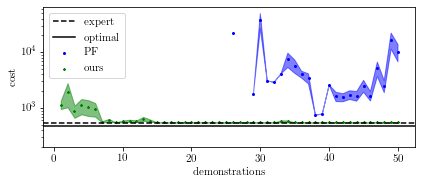

In [40]:
from utils import latexify
import matplotlib.pyplot as plt

latexify(fig_width=6, fig_height=2.7)
plt.axhline(cost_noise, ls='--', c='k', label='expert')
plt.scatter(np.arange(1,51), mean_lr, s=4, marker='o', c='blue', label='PF')
plt.fill_between(np.arange(1,51), mean_lr - std_lr / 3, mean_lr + std_lr / 3, alpha=.5, color='blue')
plt.scatter(np.arange(1,51), mean_admm, s=4, marker='*', c='green', label='ours')
plt.fill_between(np.arange(1,51), mean_admm - std_admm / 3, mean_admm + std_admm / 3, alpha=.5, color='green')
plt.semilogy()
plt.axhline(cost_true, ls='-', c='k', label='optimal')
plt.ylabel('cost')
plt.xlabel('demonstrations')
plt.legend()
plt.tight_layout()
plt.savefig("figs/aircraft_control.pdf")
plt.show()

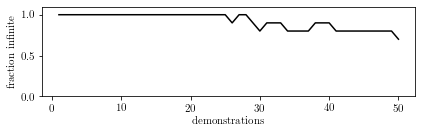

In [44]:
latexify(fig_width=6, fig_height=2)
plt.plot(np.arange(1, 51), np.isnan(costs_lr).mean(axis=1), c='k')
plt.ylim(0,1.1)
plt.xlabel("demonstrations")
plt.ylabel("fraction infinite")
plt.tight_layout()
plt.savefig("figs/inf_aircraft_control.pdf")